In [1]:
import pytrec_eval
import pandas as pd
import os
import numpy as np
import ir_datasets
import json
from repro_eval.util import arp, arp_scores

# Load run metadata

In [2]:
table = []
for run in os.listdir("../data/run"):
    parts = run.split("-")
    fields = {"dataset":  "-".join(parts[1:-4]),
    "subcollection":  parts[-4],
    "queries": parts[-3],
    "method": parts[-2],
    "implementation": parts[-1],
    "filename": run}
    table.append(fields)

In [3]:
runs = pd.DataFrame(table)

In [4]:
# runs = runs[~((runs["subcollection"]=="WT") & (runs["queries"]!="queries"))]  # longeval WT all
runs = runs[~((runs["subcollection"]=="WT") & (runs["queries"]!="test"))]  # longeval WT test only

In [5]:
# limit to systems of interrest
runs = runs[runs["method"].isin(["bm25", "bm25+colbert", "bm25+monot5", "rrf(xsqram__bm25_bo1__pl2)", "bm25_d2q10"])]

# Evaluate `arp`

In [6]:
def get_qrels_name_from_row(row):
    qrels_name = row.dataset+"-"+row.subcollection+".qrels"
    if row.queries != "queries":
        qrels_name += "-" + row.queries
    if row.dataset in qrels_type.keys():
        qrels_name += "-" + qrels_type[row.dataset]

    return qrels_name

In [7]:
def load_evaluator_with_qrels(qrels_name):
    with open("../data/qrels/"+qrels_name, "r") as file:
        qrels = pytrec_eval.parse_qrel(file)
    evaluator = pytrec_eval.RelevanceEvaluator(qrels, pytrec_eval.supported_measures)
    return evaluator

In [8]:
def evaluate_arp(row):
    evaluator = load_evaluator_with_qrels(get_qrels_name_from_row(row))
    with open("../data/run/"+row.filename, "r") as file:
        run = pytrec_eval.parse_run(file)
    arp = evaluator.evaluate(run)
    return arp

In [9]:
qrels_type = {
        "tripclick-test-head": "test-head-dctr"
}

In [10]:
runs["arp_per_topic"]=runs.apply(evaluate_arp, axis=1)

In [11]:
runs["arp"]=runs["arp_per_topic"].apply(arp_scores)

In [12]:
# explode ARP cell to generate a column per measure
runs = pd.concat([runs.drop(['arp'], axis=1), runs['arp'].apply(pd.Series)], axis=1)

# Plot ARP

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from collections import defaultdict
sns.set_style("darkgrid")

In [14]:
def plot_arp(dataset, title, measures=["ndcg", "bpref", "P_10"], symbols=["-P","-o","-v","-s", "-d", "-*"], sorted_columns=False):
    df = runs[runs["dataset"]==dataset]
    n_measures = len(measures)
    figure, axis = plt.subplots(1, n_measures, figsize=(15,5))

    for n, measure in enumerate(measures):
        if sorted_columns:
            res = df.pivot_table(index='method', columns='subcollection', values=measure)[sorted_columns].T
        else:
            res = df.pivot_table(index='method', columns='subcollection', values=measure).T

        for i, sym in enumerate(symbols):
            axis[n].plot(res.index, res[res.columns[i]], sym, alpha=0.7)
        axis[n].set_ylabel(measure)
        axis[n].set_title(measure)

    figure.subplots_adjust(bottom=0.3, wspace=0.33)
    figure.suptitle(title)
    axis[n].legend(res.columns, loc='upper center', bbox_to_anchor=(0.-0.8, -0.15), ncol=6)

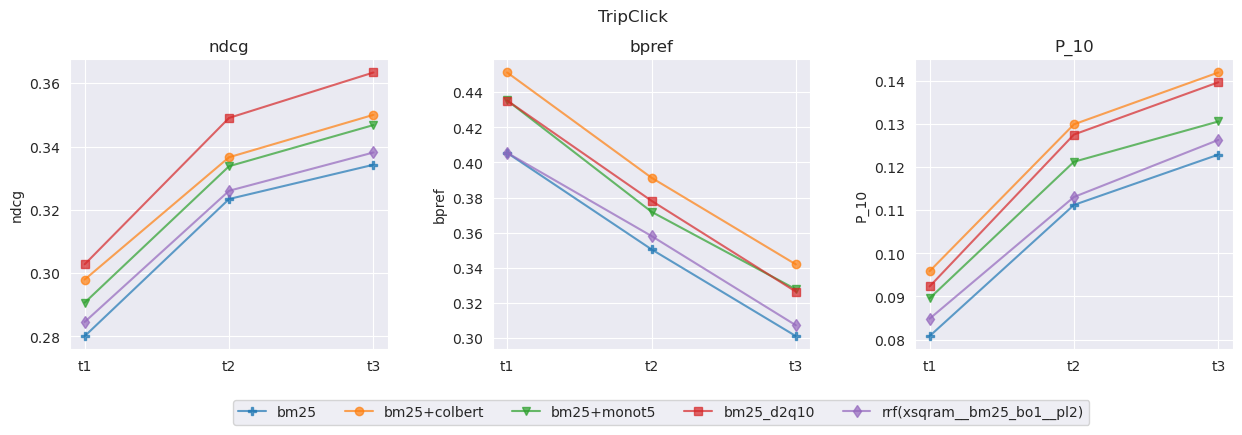

In [15]:
plot_arp("tripclick-test-head", title="TripClick", symbols=["-P","-o","-v","-s", "-d"])

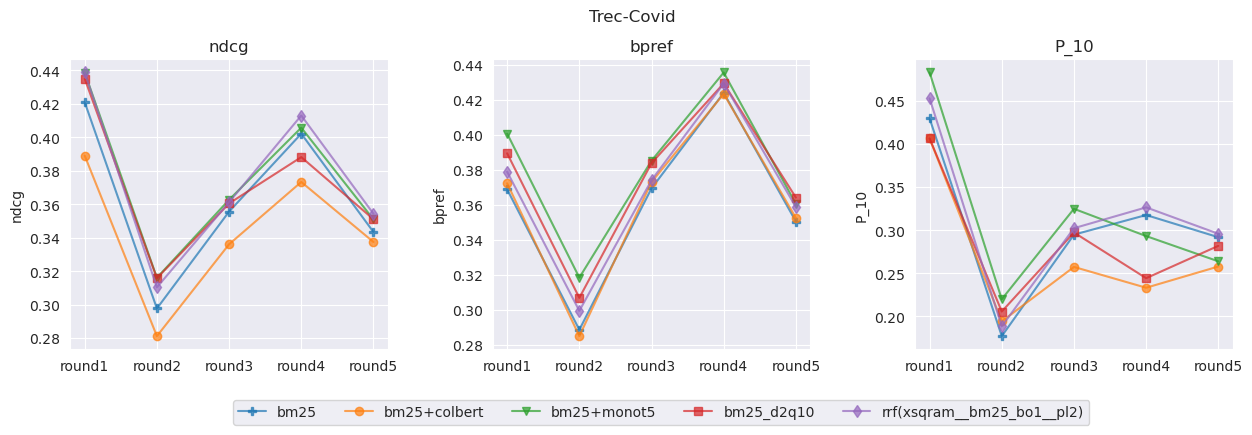

In [16]:
plot_arp("trec-covid", title="Trec-Covid", symbols=["-P","-o","-v","-s", "-d"])

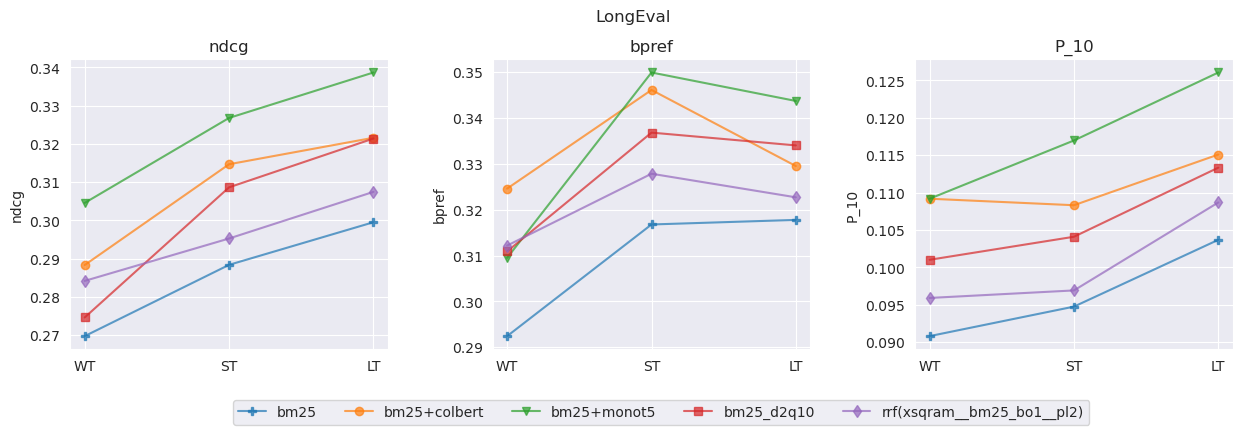

In [17]:
plot_arp("longeval", title="LongEval", symbols=["-P","-o","-v","-s", "-d"], sorted_columns=["WT", "ST", "LT"])

# Plot per topic

In [18]:
def plot_per_topic_dif(dataset, method, measure, subcollections, cut_off=1000):
    colors = ['#1f78b4', '#ff7f00', '#33a02c', '#e31a1b', "#6a3c9a", "#dbdbdb"]
    data = defaultdict(lambda: dict(zip(subcollections, [0 for _ in range(len(subcollections))])))

    fig, ax = plt.subplots(figsize=(30,5))

    for subcollection in subcollections:
        per_topic = runs[(runs["dataset"]==dataset)&(runs["subcollection"]==subcollection) & (runs["method"]==method)].iloc[0]["arp_per_topic"]

        for topic in per_topic.keys():
            data[topic][subcollection] = per_topic[topic][measure]

    data = pd.DataFrame(data).T.head(cut_off)
    # return data
    for idx, subcollection in enumerate(subcollections):
        x = data[subcollection]
        ax.plot(x, label=subcollection, color=colors[idx])
        ax.fill_between(x.index, x, 0 , alpha=0.2, color=colors[idx])

    ax.legend()
    ax.set_ylabel(measure)
    ax.set_title(dataset)

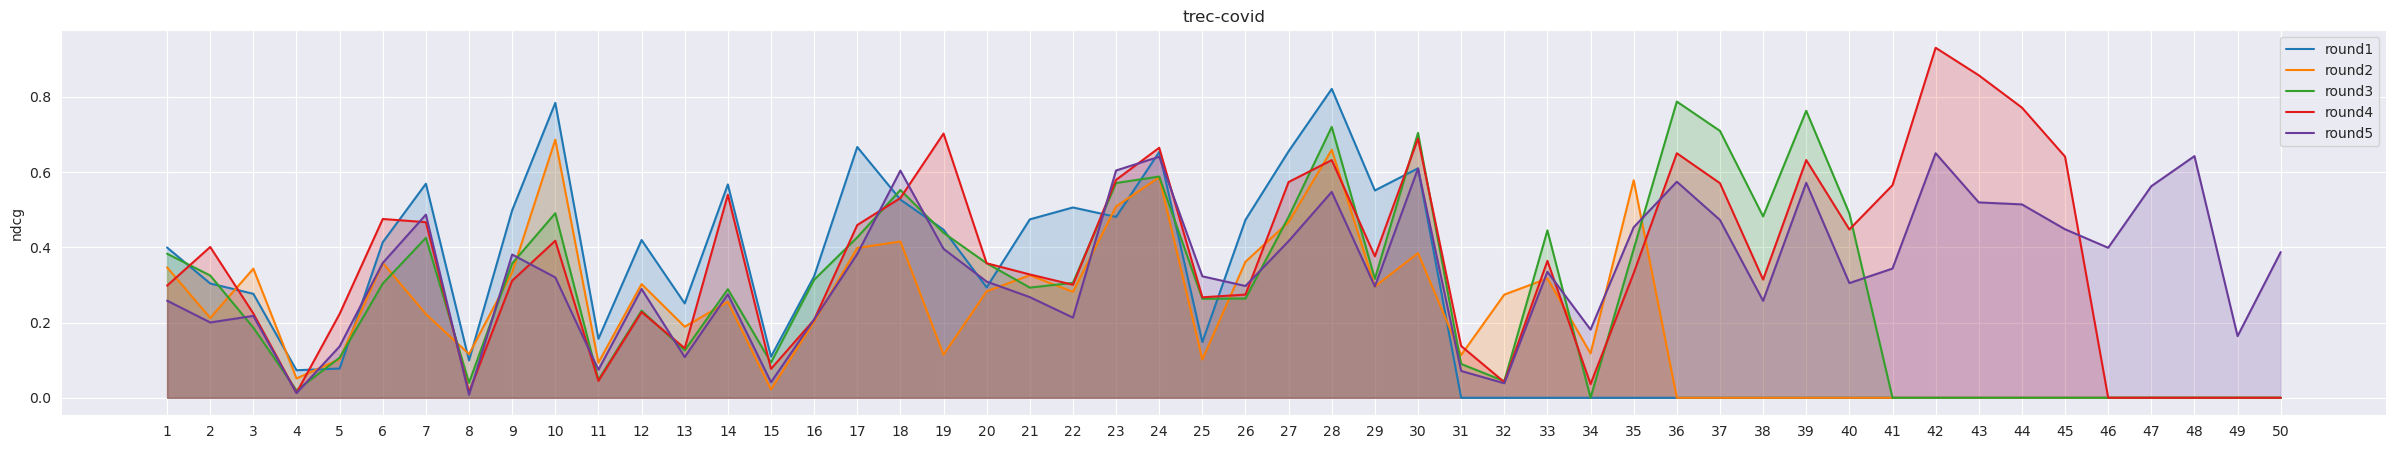

In [19]:
plot_per_topic_dif("trec-covid", "bm25", "ndcg", subcollections = ["round1", "round2", "round3", "round4", "round5"])

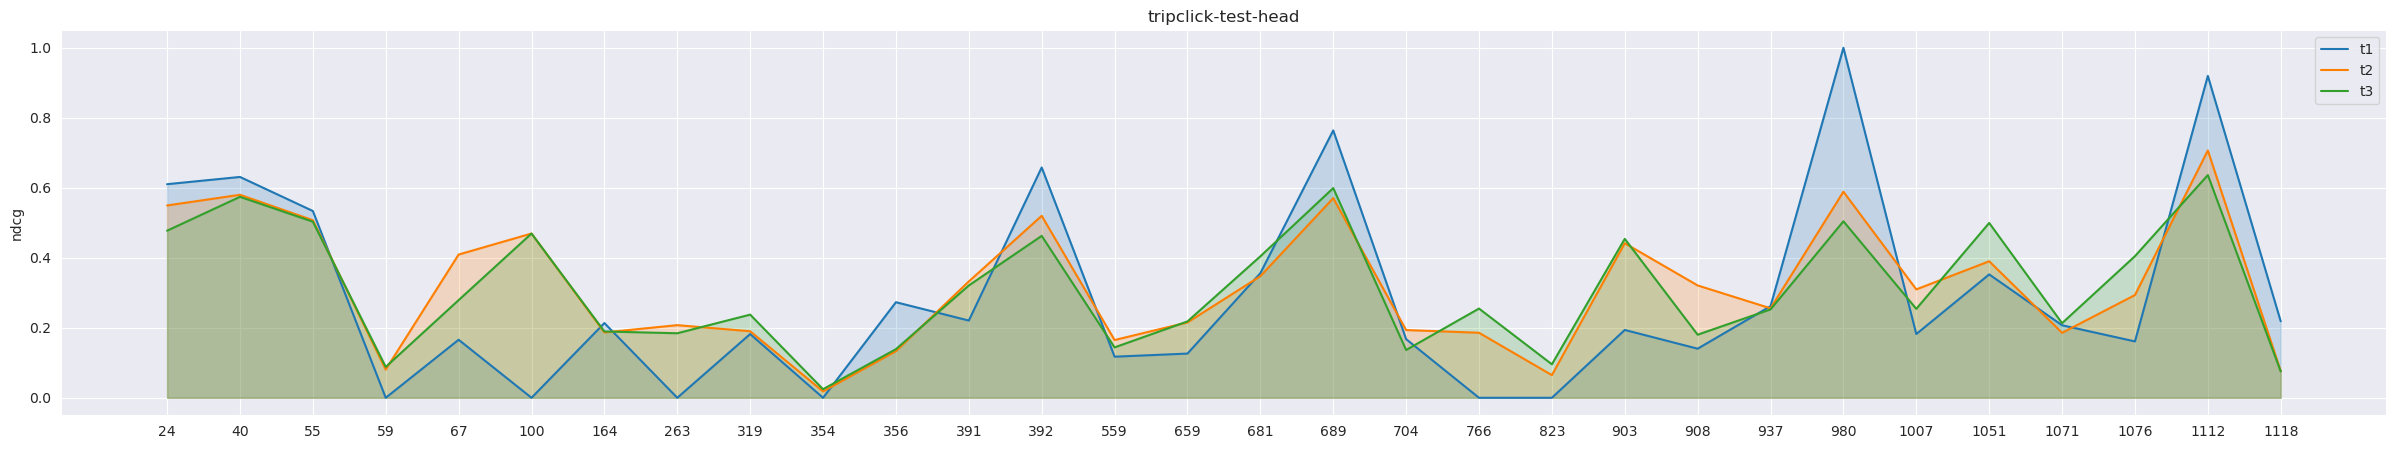

In [20]:
plot_per_topic_dif("tripclick-test-head", "bm25", "ndcg", subcollections=["t1", "t2", "t3"], cut_off=30)

In [21]:
def plot_per_topic(dataset, method, measure, subcollections, cut_off=1000):
    colors = ['#1f78b4', '#ff7f00', '#33a02c', '#e31a1b', "#6a3c9a", "#dbdbdb"]
    data = defaultdict(lambda: dict(zip(subcollections, [0 for _ in range(len(subcollections))])))

    # fig, ax = plt.subplots(figsize=(30,5))

    for subcollection in subcollections:
        per_topic = runs[(runs["dataset"]==dataset) & (runs["subcollection"]==subcollection) & (runs["method"]==method)].iloc[0]["arp_per_topic"]

        for topic in per_topic.keys():
            data[topic][subcollection] = per_topic[topic][measure]

    data = pd.DataFrame(data).T.head(cut_off)
    ax = data.plot(kind="bar", figsize=(30,5))

    ax.legend()
    ax.set_ylabel(measure)
    ax.set_title(dataset)

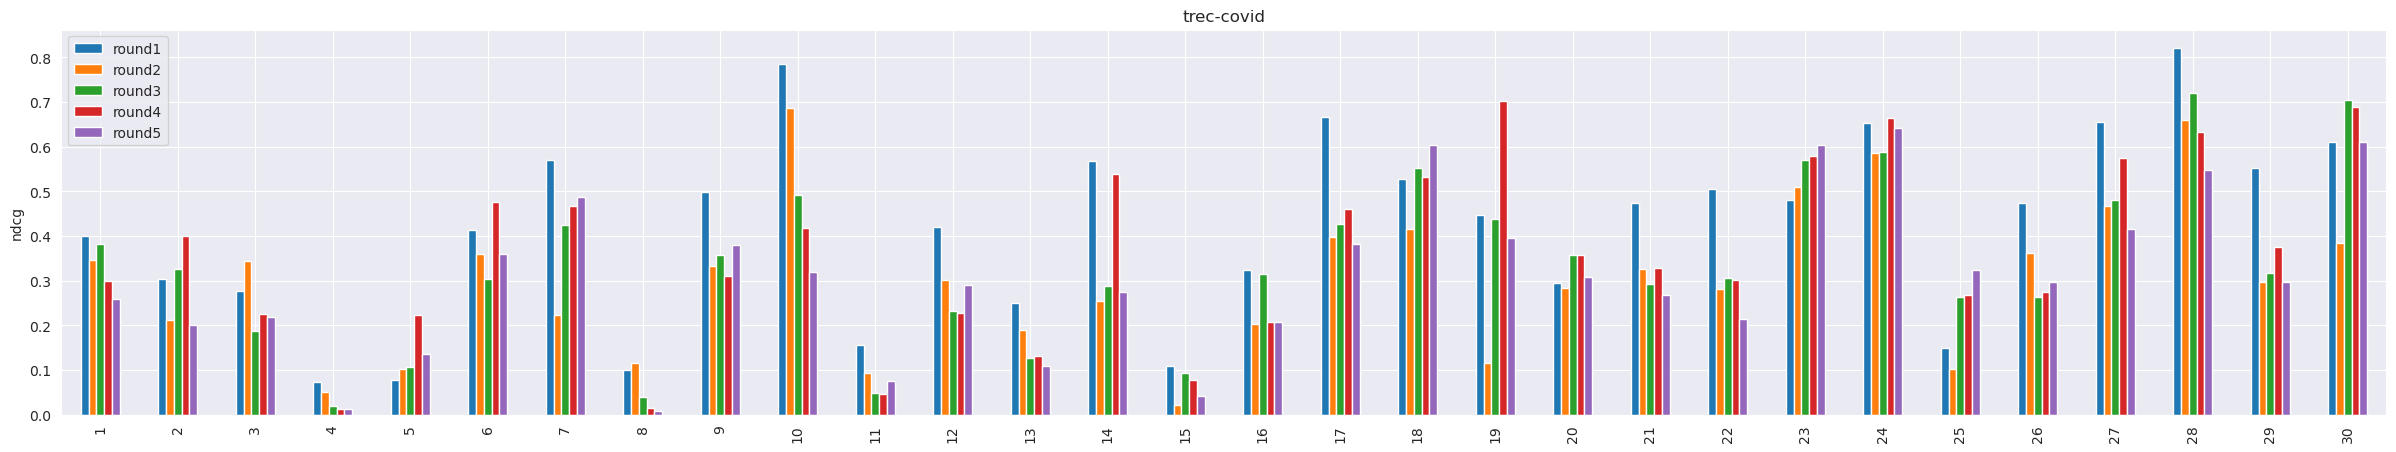

In [22]:
plot_per_topic("trec-covid", "bm25", "ndcg", subcollections = ["round1", "round2", "round3", "round4", "round5"], cut_off=30)

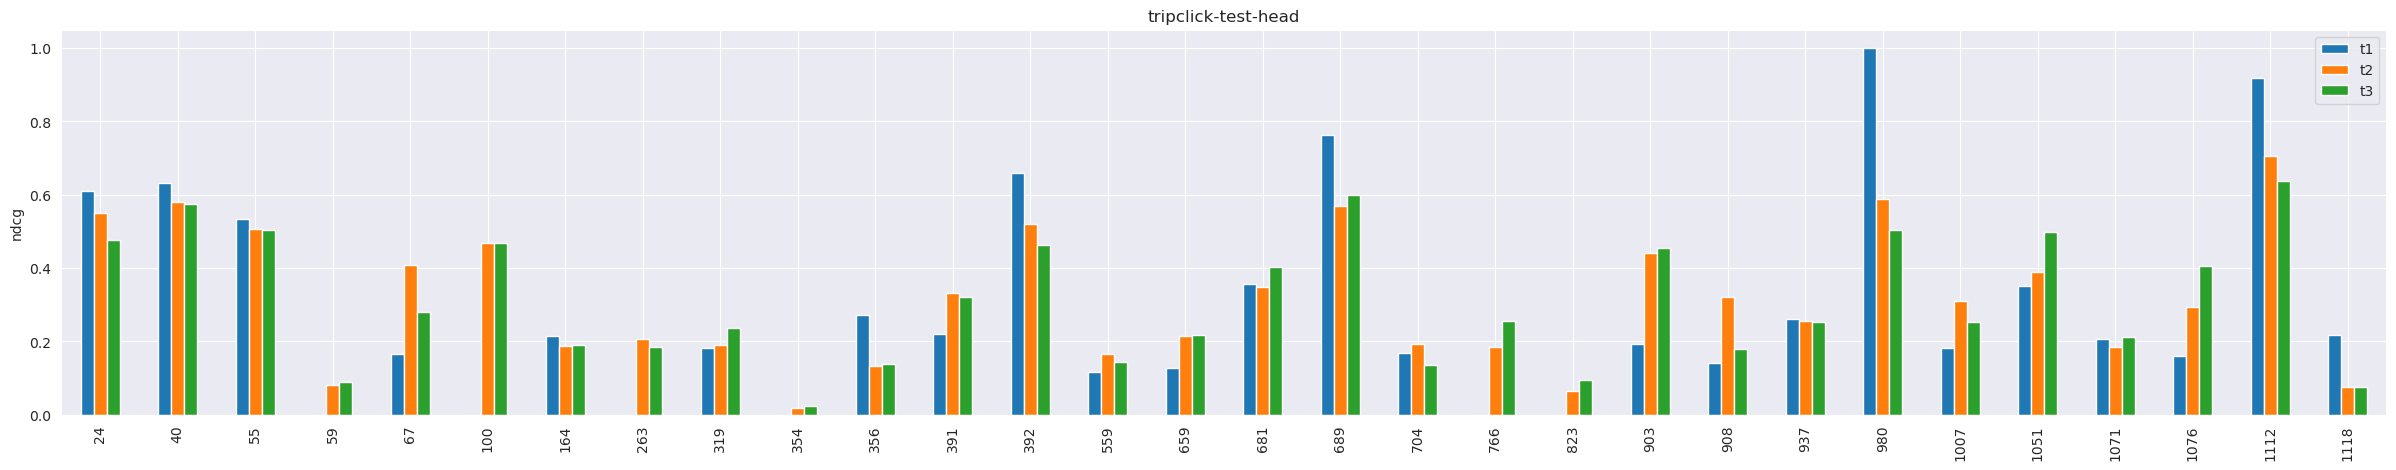

In [23]:
plot_per_topic("tripclick-test-head", "bm25", "ndcg", subcollections=["t1", "t2", "t3"], cut_off=30)

In [24]:
def plot_per_topic_delta(dataset, method, measure, subcollections, cut_off=1000):
    colors = ['#1f78b4', '#ff7f00', '#33a02c', '#e31a1b', "#6a3c9a", "#dbdbdb"]
    assert len(subcollections) == 2, "Only two subcollections allowed"
    data = defaultdict(lambda: dict(zip(subcollections, [0 for _ in range(len(subcollections))])))

    # fig, ax = plt.subplots(figsize=(30,5))

    for subcollection in subcollections:
        per_topic = runs[(runs["dataset"]==dataset) & (runs["subcollection"]==subcollection) & (runs["method"]==method)].iloc[0]["arp_per_topic"]

        for topic in per_topic.keys():
            data[topic][subcollection] = per_topic[topic][measure]

    data = pd.DataFrame(data).T.head(cut_off)

    data["delta"] = data[subcollections[0]] - data[subcollections[1]]
    ax = data["delta"].sort_values(ascending=False).plot(kind="bar", figsize=(30,5))

    ax.legend()
    ax.set_ylabel(measure)
    ax.set_title(dataset)

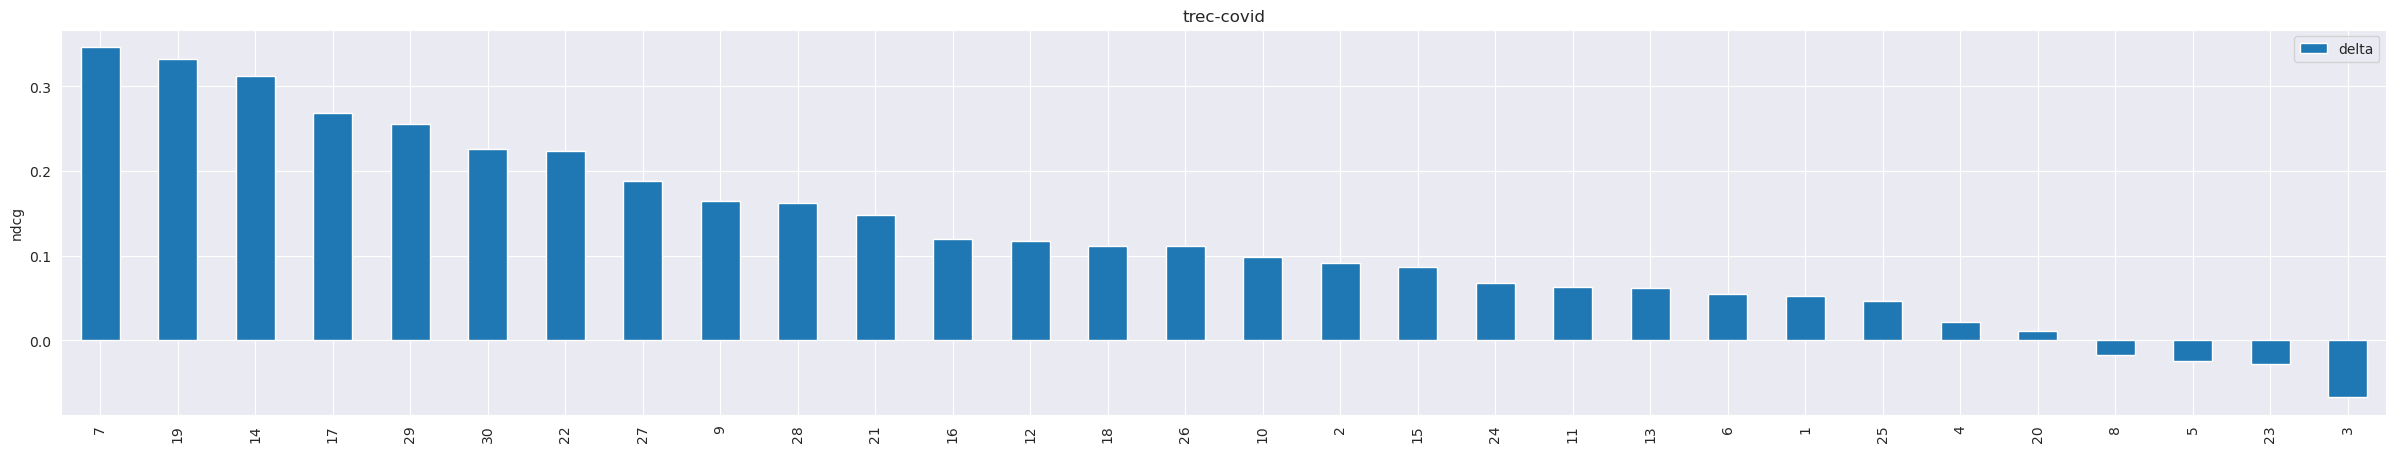

In [25]:
plot_per_topic_delta("trec-covid", "bm25", "ndcg", subcollections = ["round1", "round2"], cut_off=30)

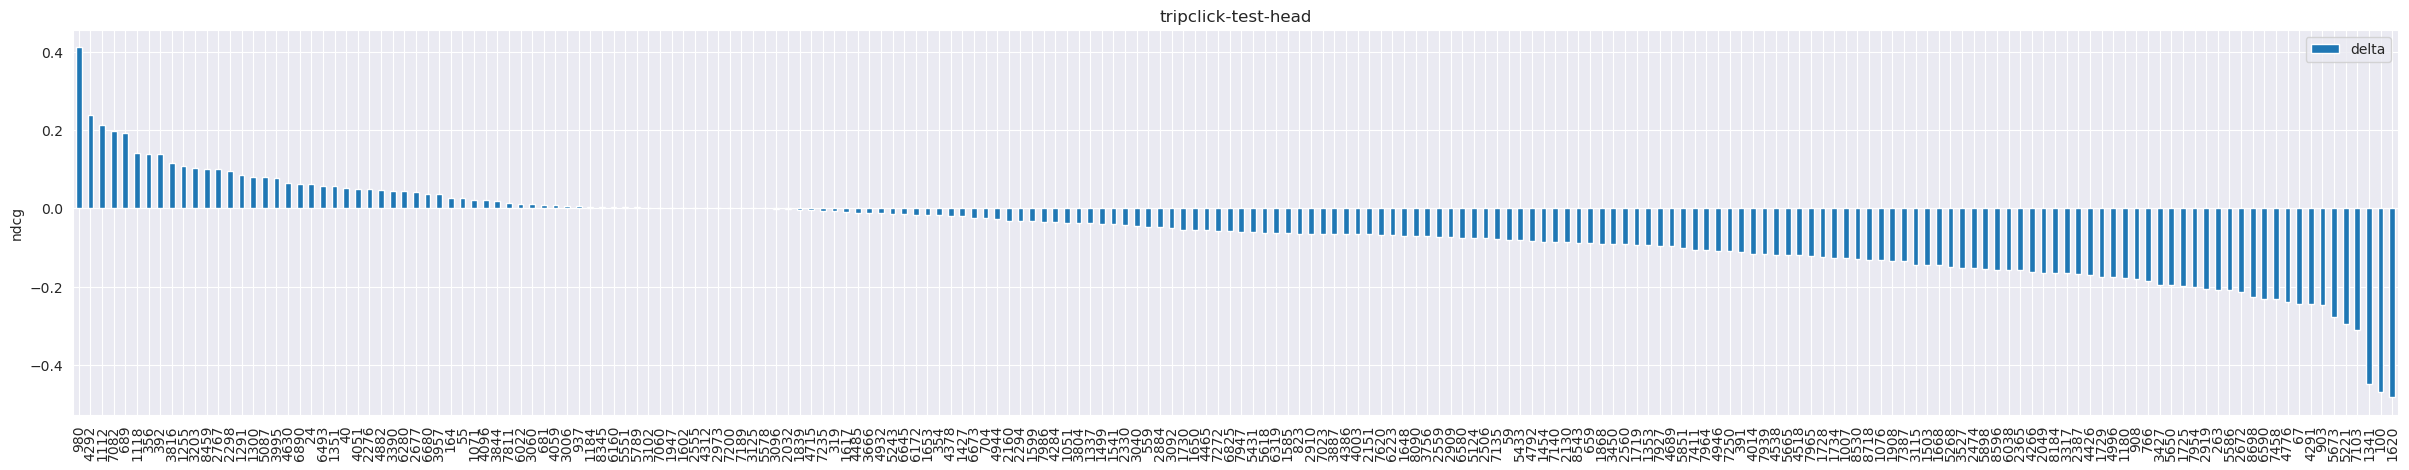

In [26]:
plot_per_topic_delta("tripclick-test-head", "bm25", "ndcg", subcollections=["t1", "t2"], cut_off=200)

# Result Table

In [27]:
def result_table(dataset, measure, subcollections):
    custom_dict = {"bm25": 0, "E5": 5, "bm25+colbert": 2, "bm25+monot5": 3, "bm25_d2q10": 4, "rrf(xsqram__bm25_bo1__pl2)": 1}
    r_patch = {
        'bm25': "BM25",
        "E5": "E5",
        'bm25+colbert': "ColBERT", 
        'rrf(xsqram__bm25_bo1__pl2)': "RRF", 
        'bm25+monot5': "MonoT5",
        'bm25_d2q10': "d2q",
    }

    df = runs[runs["dataset"]==dataset]
    columns = ["method", "subcollection"] 
    columns.append(measure)

    df = df[columns]
    df = df.pivot_table(index="method", columns="subcollection", values=measure)
    df = df.reset_index()
    df["sorter"] = df["method"].replace(custom_dict)
    df = df.sort_values("sorter").drop("sorter", axis=1)
    df = df.rename_axis(None, axis=1)
    df = df.replace({"method": r_patch})
    df["measure"] = measure
    

    # Resultdelta
    for subcollection in subcollections[1:]:
        df[subcollections[0]+"-"+subcollection] = (df[subcollections[0]]-df[subcollection])/df[subcollections[0]]
    return df

In [360]:
def highlight(table, subcollections):
    df = table.copy()

    def highlight_max(x):
        return np.where(x == np.nanmax(x.to_numpy()), "font-weight:bold;", None)

    def highlight_abs_min(x):
        x = x.to_numpy()
        
        return np.where(x == min(x.min(), x.max(), key=abs), "font-weight:bold;", None)

    subsets = []
    c = True
    

    for measure in df.index.levels[0]:

        # cols = []
        # for i in subcollections[1:]:
        #     cols.append(subcollections[0]+"-"+i)
        # delta_min = table.loc[measure][subcollections[0]+"-"+subcollection].min()
        # delta_max = table.loc[measure][subcollections[0]+"-"+subcollection].max()
        
        for subcollection in subcollections:
            subsets.append((measure, subcollection))
            # redo formatting for a specific cell
            if c:
                df = df.style.apply(highlight_max, subset=(measure, subcollection))
                c = False
            else:
                df = df.apply(highlight_max, subset=(measure, subcollection))

            df=df.background_gradient(cmap="Greens", subset=(measure, subcollection), vmin=table.loc[measure][subcollection].min(), vmax=table.loc[measure][subcollection].max())
            
            if subcollection==subcollections[0]:
                continue
            df = df.apply(highlight_abs_min, subset=(measure, subcollections[0]+"-"+subcollection))


            df=df.background_gradient(cmap="Greens", subset=(measure, subcollections[0]+"-"+subcollection), vmin=table.loc[measure][subcollections[0]+"-"+subcollection].min(), vmax=table.loc[measure][subcollections[0]+"-"+subcollection].max())

            


    return df

In [367]:
def export_table(dataset, subcollections):
    table = []
    for measure in ["ndcg", "bpref", "P_10"]:
        table.append(result_table(dataset=dataset, measure=measure, subcollections=subcollections))
        
    table = pd.concat(table).set_index(["measure", "method"])
    table_styled = highlight(table, subcollections)
    table_styled = table_styled.format_index(escape="latex").format(precision=2)
    table_styled.to_latex(f"../../../paper/ECIR23/tables/ARP_{dataset}.tex", convert_css=True)


In [368]:
export_table(dataset="tripclick-test-head", subcollections=["t1", "t2", "t3"])
export_table(dataset="longeval", subcollections=["WT", "ST", "LT"])
export_table(dataset="trec-covid", subcollections=["round1", "round2", "round3", "round4", "round5"])

# Replicability

In [32]:
from repro_eval.Evaluator import RpdEvaluator, RplEvaluator

In [33]:
def evaluate_replicability(row):
    # This fails if topics are in the advanced run but not in the baseline run. This is the case if the baseline run retrieves 0 docs for a topic but an advanced system retrieves any, for example, because it bridges the lexical gap. 
    try:
        # Original
        # get qrel baseline
        qrel_orig_path = get_qrels_name_from_row(runs_b_orig[runs_b_orig["dataset"] == row["dataset"]].iloc[0])
        # baseline
        run_b_orig_path = runs_b_orig[runs_b_orig["dataset"] == row["dataset"]].iloc[0]["filename"]
        # advanced
        run_a_orig_path = runs_a_orig[(runs_a_orig["dataset"]==row["dataset"]) & (runs_a_orig["method"]==row["method"])].iloc[0]["filename"]


        # Replicated
        # get baseline
        run_b_rep_path = runs_b_rep[runs_b_rep["subcollection"] == row["subcollection"]].iloc[0]["filename"]
        # get qrel advanced
        qrel_rpl_path = get_qrels_name_from_row(row)


        rpl_eval = RplEvaluator(qrel_orig_path="../data/qrels/"+ qrel_orig_path,
                            run_b_orig_path="../data/run/"+ run_b_orig_path,
                            run_a_orig_path="../data/run/"+ run_a_orig_path,
                            run_b_rep_path="../data/run/"+run_b_rep_path,
                            run_a_rep_path="../data/run/"+row["filename"],
                            qrel_rpl_path="../data/qrels/"+qrel_rpl_path)
        
        
        rpl_eval.trim()
        rpl_eval.evaluate()
        ret = {"dri": rpl_eval.dri(), "er": rpl_eval.er(), "pval": rpl_eval.ttest()}
    except:
        print("Error in", row["filename"])
        
        ret = {"dri": np.nan, "er": np.nan, "pval": np.nan}
    return ret

In [34]:
runs_b_orig = runs[(runs["subcollection"].isin(["WT", "t1", "round1"])) & (runs["method"]=="bm25")]
runs_a_orig = runs[(runs["subcollection"].isin(["WT", "t1", "round1"])) & (runs["method"]!="bm25")]

runs_b_rep = runs[(~runs["subcollection"].isin(["WT", "t1", "round1"])) & (runs["method"]=="bm25")]
runs_a_rep = runs[(~runs["subcollection"].isin(["WT", "t1", "round1"])) & (runs["method"]!="bm25")]

In [35]:
runs_a_rep["replicability"] = runs_a_rep.apply(evaluate_replicability, axis=1)

/home/jueri/miniconda3/envs/LongEval/lib/python3.8/site-packages/repro_eval/measure/overall_effects.py:82: RuntimeWarning: divide by zero encountered in double_scalars
  yield measure, value / mi_orig.get(measure)
/home/jueri/miniconda3/envs/LongEval/lib/python3.8/site-packages/repro_eval/measure/overall_effects.py:82: RuntimeWarning: invalid value encountered in double_scalars
  yield measure, value / mi_orig.get(measure)
/home/jueri/miniconda3/envs/LongEval/lib/python3.8/site-packages/repro_eval/measure/overall_effects.py:142: RuntimeWarning: invalid value encountered in double_scalars
  yield measure, (mean - mean_scores_b.get(measure)) / mean_scores_b.get(measure)


Error in run-longeval-LT-test-bm25_d2q10-pyterrier


/tmp/ipykernel_17765/367386148.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  runs_a_rep["replicability"] = runs_a_rep.apply(evaluate_replicability, axis=1)


In [36]:
runs_a_rep = pd.concat([runs_a_rep.drop(['replicability'], axis=1), runs_a_rep['replicability'].apply(pd.Series)], axis=1)
runs_a_rep = pd.concat([runs_a_rep.drop(['dri'], axis=1), runs_a_rep["dri"].apply(pd.Series).add_prefix('DRI_')], axis=1)
runs_a_rep = pd.concat([runs_a_rep.drop(['er'], axis=1), runs_a_rep["er"].apply(pd.Series).add_prefix('ER_')], axis=1)
runs_a_rep = pd.concat([runs_a_rep.drop(['pval'], axis=1), runs_a_rep["pval"].apply(pd.Series).add_prefix('PVAL_')], axis=1)
runs_a_rep = pd.concat([runs_a_rep.drop(['PVAL_advanced'], axis=1), runs_a_rep["PVAL_advanced"].apply(pd.Series).add_prefix('PVAL_')], axis=1)

In [37]:
from adjustText import adjust_text

r_patch = {
    'bm25+colbert': "ColBERT", 
    'rrf(xsqram__bm25_bo1__pl2)': "RRF", 
    'bm25+monot5': "MonoT5",
    'bm25_d2q10': "d2q",
}

In [38]:
def plot_ER_DRI(data):
    measures = ['P_10', 'bpref', 'ndcg']
    marker_color = [('o', "#1f78b4"), ('^', '#33a02c'), ('v', '#e31a1b')]

    fig, ax1 = plt.subplots(figsize=(7, 7))

    ax1.tick_params(axis='y', labelcolor='k')
    ax1.axhline(0, color='grey')  
    ax1.axvline(1, color='grey')

    ax1.grid(False)  # disable grid
    ax1.set_xlabel('Effect Ratio (ER)')
    ax1.set_ylabel(u'Delta Relative Improvement ($\Delta$RI)')

    for measure, mk in zip(measures, marker_color):
        ax1.plot(data[f"ER_{measure}"].clip(0,2),
                data[f"DRI_{measure}"].clip(-0.1,0.1),
                marker=mk[0], color=mk[1], linestyle='None', label=measure)

    # fig.tight_layout()
    ax1.legend(loc='lower left')

    dataset = data["dataset"].iloc[0]
    subcollection = data["subcollection"].iloc[0]
    ax1.set_title(f'{dataset} in {subcollection}\n')
    # plt.title(f'Replicability of {dataset} in {subcollection}\n')

    texts = []

    for m in measures:
        for r in data["method"].to_list():
            texts.append(ax1.text(
                x = data[data["method"]==r][f"ER_{m}"].clip(0,2).values[0], 
                y = data[data["method"]==r][f"DRI_{m}"].clip(-0.1,0.1).values[0],
                s = r_patch[r]))

    ax1.set_ylim(-0.1,0.1)
    ax1.set_xlim(0,2)

    _ = adjust_text(texts, ax=ax1)    
    # return ax1
    plt.savefig(f"../../../paper/ECIR23/figures/ER_DRI_{dataset}-{subcollection}.pdf", bbox_inches='tight')
    plt.show()


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


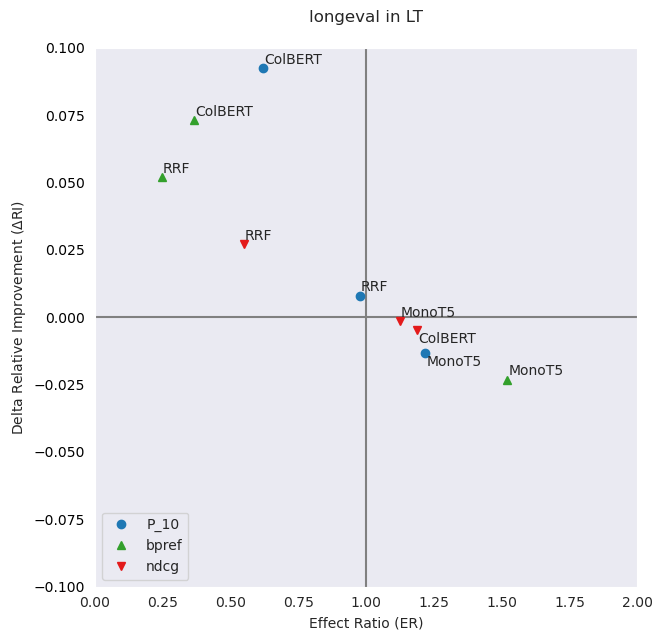

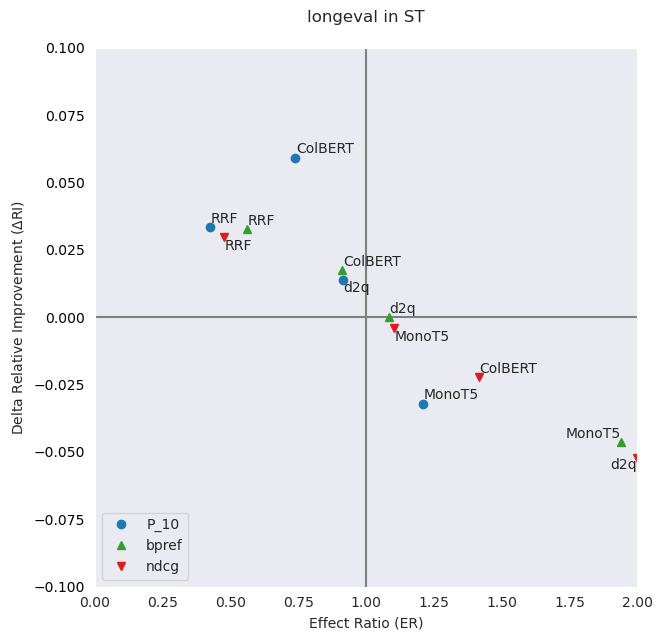

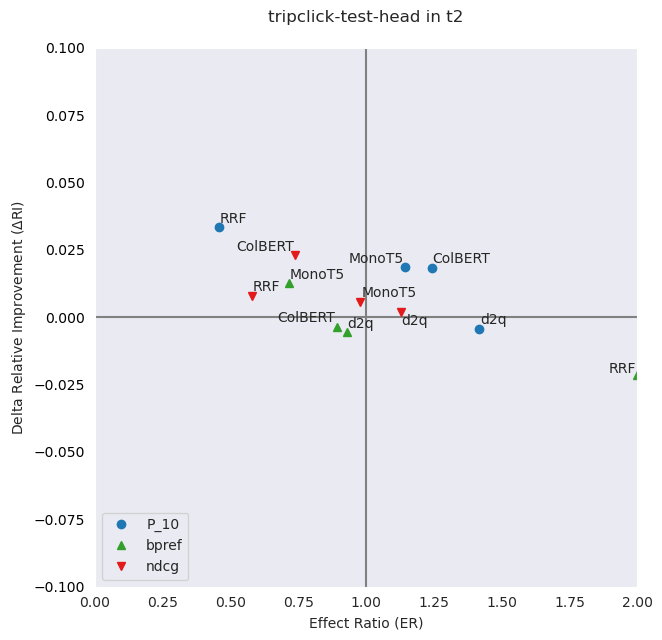

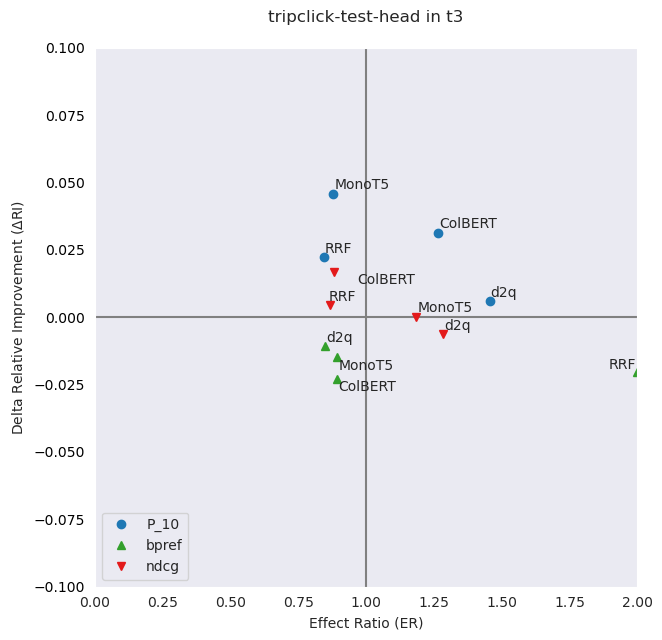

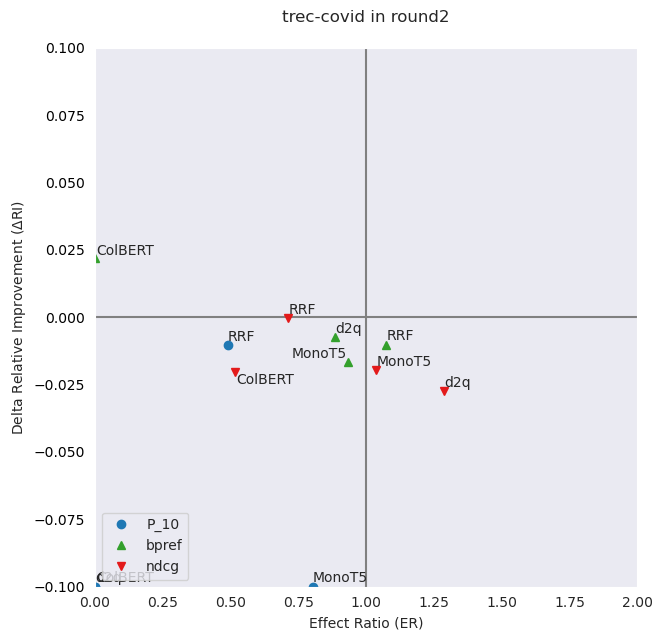

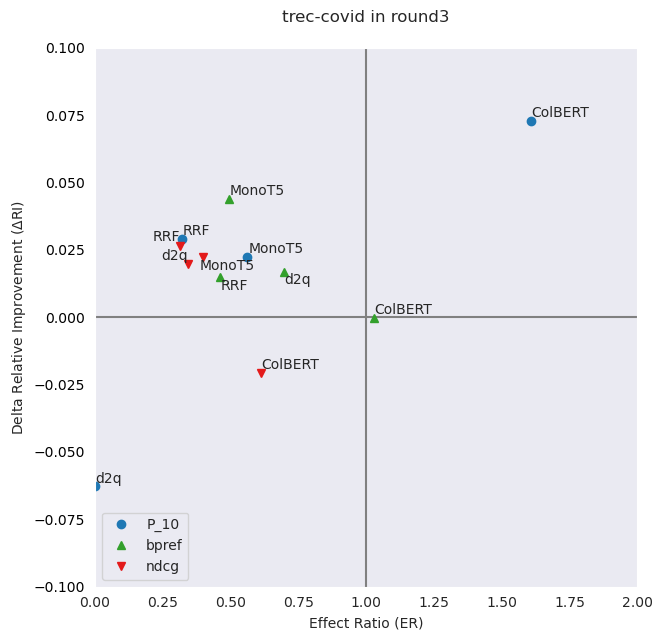

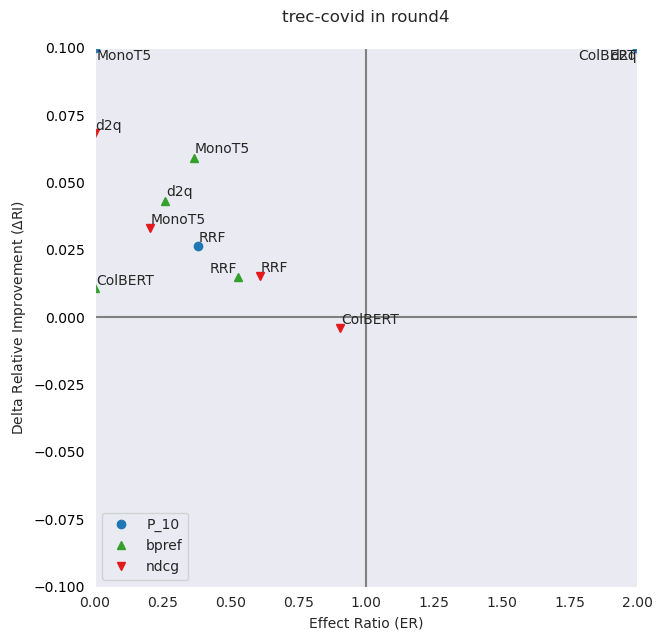

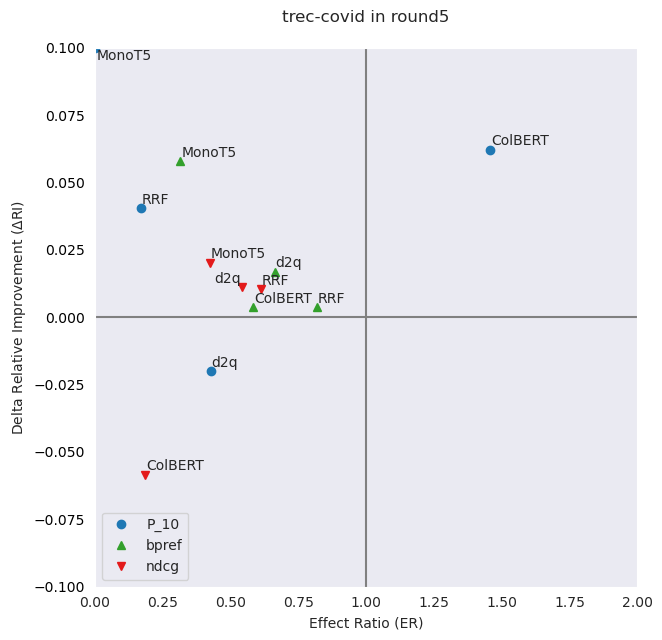

In [39]:
datasets = runs_a_rep["dataset"].unique()
for dataset in datasets:
    subcollections = runs_a_rep[runs_a_rep["dataset"]==dataset]["subcollection"].unique()
    # figure, axis = plt.subplots(1, len(subcollections), figsize=(5 * len(subcollections),5))
    
    for idx, subcollection in enumerate(sorted(subcollections)):
        data = runs_a_rep[(runs_a_rep["dataset"]==dataset) & (runs_a_rep["subcollection"]==subcollection)]

        plot_ER_DRI(data)
    #     axis[idx] = plot_ER_DRI(data, ax1=axis[idx])
    #     axis[idx].set_ylim(-0.1,0.1)
    #     axis[idx].set_xlim(0,2)
    # figure.tight_layout()